<a href="https://colab.research.google.com/github/aneveu23/WSABI-Best-Ball-Draft-Wizard/blob/main/Eric_gamescore_run_pct_correlation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install nfl_data_py
!python3 -m pip install pystan
!pip3 install nest_asyncio


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.5 MB/s eta 0:00:00
  Created wheel for nfl_data_py: filename=nfl_data_py-0.3.1-py3-none-any.whl size=13188 sha256=bd7d501b689dff5980a361ebcf53ceeaebbcf5b7052f1acc6fe1fd3e534e46c7
  Stored in directory: /root/.cache/pip/wheels/ca/2e/d2/4def312ac7c070e1c0002e91ecc6923481a86c3ebd5b2c5413
Successfully built nfl_data_py
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 57.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.3 MB/s eta 0:00:00


In [2]:
import nfl_data_py as nfl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import stan
import nest_asyncio
import seaborn as sns

from google.colab import drive


In [3]:
drive.mount('drive')

Mounted at drive


In [4]:
data = nfl.import_weekly_data([2021, 2022, 2023], columns = ['player_display_name', 'position', 'fantasy_points_ppr', 'week', 'season', 'recent_team', 'opponent_team'])
data.columns = ['player', 'position', 'ppr', 'week', 'season', 'team', 'opponent_team']
data = data[(data['week'] <= 18)]
data.head()

Downcasting floats.


,player,position,ppr,week,season,team,opponent_team
0,Tom Brady,QB,27.160000,1,2021,TB,DAL
1,Tom Brady,QB,29.639999,2,2021,TB,ATL
2,Tom Brady,QB,28.680000,3,2021,TB,LA
3,Tom Brady,QB,11.060000,4,2021,TB,NE
4,Tom Brady,QB,37.740002,5,2021,TB,MIA


In [5]:
games = nfl.import_schedules([2021, 2022, 2023])
games = games.loc[:,['season', 'week', 'home_team', 'home_score', 'away_team', 'away_score']]
games = games.sort_values(['home_team', 'season', 'week'])
games.head()

,season,week,home_team,home_score,away_team,away_score
5878,2021,2,ARI,34.0,MIN,33.0
5928,2021,5,ARI,17.0,SF,10.0
5955,2021,7,ARI,31.0,HOU,5.0
5959,2021,8,ARI,21.0,GB,24.0
5996,2021,10,ARI,10.0,CAR,34.0


Get play type distribution and run%

In [6]:
plays = nfl.import_pbp_data([2021, 2022, 2023])

2021 done.
2022 done.
2023 done.
Downcasting floats.


In [7]:
plays['play_type'].unique()

array([None, 'kickoff', 'run', 'pass', 'punt', 'no_play', 'field_goal',
       'extra_point', 'qb_spike', 'qb_kneel'], dtype=object)

In [8]:
plays = plays.loc[:,['season', 'week', 'posteam', 'defteam', 'play_type']]
play_type_counts = plays.groupby(['season', 'posteam'])['play_type'].value_counts().unstack(fill_value=0)
play_type_counts = play_type_counts.sort_values(['posteam', 'season'])
play_type_counts = play_type_counts.reindex(columns = ['run', 'pass', 'punt', 'kickoff', 'field_goal', 'extra_point', 'qb_spike', 'qb_kneel', 'no_play'])
play_type_counts['run%'] = np.zeros(len(play_type_counts))

for i in range(len(play_type_counts)):
    play_type_counts.iloc[i, -1] = (play_type_counts.iloc[i, 0]) / (play_type_counts.iloc[i, 0] + play_type_counts.iloc[i, 1])
play_type_counts = play_type_counts.reset_index()

In [9]:
play_type_counts.head()

play_type,season,posteam,run,pass,punt,kickoff,field_goal,extra_point,qb_spike,qb_kneel,no_play,run%
0,2021,ARI,497,669,57,86,38,49,0,17,89,0.426244
1,2022,ARI,429,713,68,94,32,27,4,7,83,0.375657
2,2023,ARI,469,602,64,94,33,23,1,8,90,0.437908
3,2021,ATL,384,614,66,97,29,30,1,10,80,0.384770
4,2022,ATL,550,450,62,91,37,35,4,10,61,0.550000


In [ ]:
play_type_counts.head(50)

,play_type,run,pass,punt,kickoff,field_goal,extra_point,qb_spike,qb_kneel,no_play,run%
season,posteam,,,,,,,,,,
2021,ARI,497,669,57,86,38,49,0,17,89,0.426244
2022,ARI,429,713,68,94,32,27,4,7,83,0.375657
2023,ARI,469,602,64,94,33,23,1,8,90,0.437908
2021,ATL,384,614,66,97,29,30,1,10,80,0.384770
2022,ATL,550,450,62,91,37,35,4,10,61,0.550000
2023,ATL,514,569,75,91,37,28,4,9,68,0.474608
2021,BAL,509,668,71,85,37,32,7,9,78,0.432455
2022,BAL,543,553,60,81,44,34,5,19,65,0.495438
2023,BAL,586,601,76,81,40,57,1,14,86,0.493682


In [10]:
run_pct_sorted = play_type_counts.sort_values(by = ['run%'], ascending = False)
run_pct_sorted.head(40)

play_type,season,posteam,run,pass,punt,kickoff,field_goal,extra_point,qb_spike,qb_kneel,no_play,run%
16,2022,CHI,546,439,67,94,27,32,1,12,61,0.554315
4,2022,ATL,550,450,62,91,37,35,4,10,61,0.550000
7,2022,BAL,543,553,60,81,44,34,5,19,65,0.495438
13,2022,CAR,480,491,81,82,35,32,3,6,73,0.494336
8,2023,BAL,586,601,76,81,40,57,1,14,86,0.493682
75,2021,PHI,557,573,61,91,33,45,2,12,73,0.492920
76,2022,PHI,643,671,65,87,29,67,1,25,96,0.489346
91,2022,TEN,474,505,90,83,24,33,1,13,73,0.484168
90,2021,TEN,565,607,62,90,33,48,1,15,88,0.482082
17,2023,CHI,523,566,67,81,38,33,0,12,66,0.480257


In [9]:
player_seasons = data.groupby(['player', 'season', 'position', 'team'])['ppr'].sum().reset_index()
player_seasons

,player,season,position,team,ppr
0,A.J. Brown,2021,WR,TEN,180.899994
1,A.J. Brown,2022,WR,PHI,299.600006
2,A.J. Brown,2023,WR,PHI,289.600006
3,A.J. Dillon,2021,RB,GB,185.599991
4,A.J. Dillon,2022,RB,GB,167.600006
...,...,...,...,...,...
1915,Zay Jones,2021,WR,LV,105.900002
1916,Zay Jones,2022,WR,JAX,198.100006
1917,Zay Jones,2023,WR,JAX,78.099998
1918,Zonovan Knight,2022,RB,NYJ,59.000000


In [10]:
# helper function to get 2nd highest value in each group
def get_second_largest(group):
    return group.nlargest(2, 'ppr').iloc[1]

Get individual dataframes for each position

In [11]:
qb = data[(data['position'] == 'QB')].sort_values(by = ['team', 'season', 'week'])
rb = data[(data['position'] == 'RB')].sort_values(by = ['team', 'season', 'week'])
wr = data[(data['position'] == 'WR')].sort_values(by = ['team', 'season', 'week'])
te = data[(data['position'] == 'TE')].sort_values(by = ['team', 'season', 'week'])

Get season-level dataframes of the best/2nd best player at a position on each team

In [12]:
qbs = player_seasons[(player_seasons)['position'] == 'QB'].sort_values(by = ['team', 'season'])
idx = qbs.groupby(['team', 'season'])['ppr'].idxmax()
qbs = qbs.loc[idx]

rb1s = player_seasons[(player_seasons)['position'] == 'RB'].sort_values(by = ['team', 'season'])
idx = rb1s.groupby(['team', 'season'])['ppr'].idxmax()
rb1s = rb1s.loc[idx]

rb2s = player_seasons[(player_seasons)['position'] == 'RB'].sort_values(by = ['team', 'season'])
rb2s = rb2s.groupby(['team', 'season']).apply(get_second_largest).reset_index(drop = True)

wr1s = player_seasons[(player_seasons)['position'] == 'WR'].sort_values(by = ['team', 'season'])
idx = wr1s.groupby(['team', 'season'])['ppr'].idxmax()
wr1s = wr1s.loc[idx]

wr2s = player_seasons[(player_seasons)['position'] == 'WR'].sort_values(by = ['team', 'season'])
wr2s = wr2s.groupby(['team', 'season']).apply(get_second_largest).reset_index(drop = True)

tes = player_seasons[(player_seasons)['position'] == 'TE'].sort_values(by = ['team', 'season'])
idx = tes.groupby(['team', 'season'])['ppr'].idxmax()
tes = tes.loc[idx]

Get week-level dataframes for each position

In [17]:
qb = pd.merge(qb, qbs, on = ['player', 'team', 'season'], how = 'inner')
rb1 = pd.merge(rb, rb1s, on = ['player', 'team', 'season'], how = 'inner')
rb2 = pd.merge(rb, rb2s, on = ['player', 'team', 'season'], how = 'inner')
wr1 = pd.merge(wr, wr1s, on = ['player', 'team', 'season'], how = 'inner')
wr2 = pd.merge(wr, wr2s, on = ['player', 'team', 'season'], how = 'inner')
te = pd.merge(te, tes, on = ['player', 'team', 'season'], how = 'inner')

Get matchup dataframe

In [16]:
games['season'].unique()

array([2021, 2022, 2023])

In [18]:
matchups = data[['season', 'week', 'team', 'opponent_team']].drop_duplicates().sort_values(['team', 'season', 'week'])

print(len(matchups))
matchups = matchups.drop(matchups[matchups['team'] == matchups['opponent_team']].index)
print(len(matchups))

matchups['team_score'] = np.zeros(len(matchups))
matchups['opp_score'] = np.zeros(len(matchups))

for i in range(len(matchups)):
    game_row = games[(games['week'] == matchups.iloc[i, 1]) & (games['season'] == matchups.iloc[i, 0]) &
                              ((games['home_team'] == matchups.iloc[i, 2]) | (games['home_team'] == matchups.iloc[i, 3]))]
    matchups.iloc[i, 4] = game_row.iloc[0, 3]
    matchups.iloc[i, 5] = game_row.iloc[0, 5]



1653
1629


In [ ]:
matchups

,season,week,team,opponent_team,team_score,opp_score
235,2021,1,ARI,TEN,13.0,38.0
236,2021,2,ARI,MIN,34.0,33.0
237,2021,3,ARI,JAX,19.0,31.0
197,2021,4,ARI,LA,20.0,37.0
239,2021,5,ARI,SF,17.0,10.0
...,...,...,...,...,...,...
323,2023,13,WAS,MIA,15.0,45.0
160,2023,15,WAS,LA,28.0,20.0
325,2023,16,WAS,NYJ,30.0,28.0
326,2023,17,WAS,SF,10.0,27.0


In [19]:
position_df_data = {
    'season' : [],
    'week' : [],
    'team' : [],
    'opponent_team' : [],
    'qb' : [],
    'rb1' : [],
    'rb2' : [],
    'wr1' : [],
    'wr2' : [],
    'te' : [],
    'opp_qb' : [],
    'opp_rb1' : [],
    'opp_rb2' : [],
    'opp_wr1' : [],
    'opp_wr2' : [],
    'opp_te' : [],
    'team_score' : [],
    'opp_score' : [],
    'run_pct' : [],
    'opp_run_pct' : []
}

position_df = pd.DataFrame(position_df_data)

In [20]:
teams = matchups['team'].unique()

In [21]:
for season in range(2021,2024):
  for team in range(32):
    for week in range(18):

      # get team points for each position-week
      qb_row = qb[(qb['season'] == season) & (qb['team'] == teams[team]) & (qb['week'] == week+1)]
      rb1_row = rb1[(rb1['season'] == season) & (rb1['team'] == teams[team]) & (rb1['week'] == week+1)]
      rb2_row = rb2[(rb2['season'] == season) & (rb2['team'] == teams[team]) & (rb2['week'] == week+1)]
      wr1_row = wr1[(wr1['season'] == season) & (wr1['team'] == teams[team]) & (wr1['week'] == week+1)]
      wr2_row = wr2[(wr2['season'] == season) & (wr2['team'] == teams[team]) & (wr2['week'] == week+1)]
      te_row = te[(te['season'] == season) & (te['team'] == teams[team]) & (te['week'] == week+1)]

      qb_ppr = 0 if (qb_row.empty) else qb_row.iloc[0, 2]
      rb1_ppr = 0 if (rb1_row.empty) else rb1_row.iloc[0, 2]
      rb2_ppr = 0 if (rb2_row.empty) else rb2_row.iloc[0, 2]
      wr1_ppr = 0 if (wr1_row.empty) else wr1_row.iloc[0, 2]
      wr2_ppr = 0 if (wr2_row.empty) else wr2_row.iloc[0, 2]
      te_ppr = 0 if (te_row.empty) else te_row.iloc[0, 2]

      # get opposing team points
      matchup_row = matchups[(matchups['season'] == season) & (matchups['week'] == week+1) & (matchups['team'] == teams[team])]
      if (not matchup_row.empty):
        opponent = matchup_row.iloc[0, 3]
        curr_team = teams[team]

        opp_qb_row = qb[(qb['season'] == season) & (qb['team'] == opponent) & (qb['week'] == week+1)]
        opp_rb1_row = rb1[(rb1['season'] == season) & (rb1['team'] == opponent) & (rb1['week'] == week+1)]
        opp_rb2_row = rb2[(rb2['season'] == season) & (rb2['team'] == opponent) & (rb2['week'] == week+1)]
        opp_wr1_row = wr1[(wr1['season'] == season) & (wr1['team'] == opponent) & (wr1['week'] == week+1)]
        opp_wr2_row = wr2[(wr2['season'] == season) & (wr2['team'] == opponent) & (wr2['week'] == week+1)]
        opp_te_row = te[(te['season'] == season) & (te['team'] == opponent) & (te['week'] == week+1)]

        opp_qb_ppr = 0 if (opp_qb_row.empty) else opp_qb_row.iloc[0, 2]
        opp_rb1_ppr = 0 if (opp_rb1_row.empty) else opp_rb1_row.iloc[0, 2]
        opp_rb2_ppr = 0 if (opp_rb2_row.empty) else opp_rb2_row.iloc[0, 2]
        opp_wr1_ppr = 0 if (opp_wr1_row.empty) else opp_wr1_row.iloc[0, 2]
        opp_wr2_ppr = 0 if (opp_wr2_row.empty) else opp_wr2_row.iloc[0, 2]
        opp_te_ppr = 0 if (opp_te_row.empty) else opp_te_row.iloc[0, 2]

        team_score = matchup_row.iloc[0, 4]
        opp_score = matchup_row.iloc[0, 5]

        play_type_row = play_type_counts[(play_type_counts['season'] == season) & (play_type_counts['posteam'] == curr_team)]
        run_pct = play_type_row.iloc[0, -1]

        opp_play_type_row = play_type_counts[(play_type_counts['season'] == season) & (play_type_counts['posteam'] == opponent)]
        opp_run_pct = opp_play_type_row.iloc[0, -1]

        new_row = {
          'season' : season,
          'week' : week+1,
          'team' : curr_team,
          'opponent_team' : opponent,
          'qb' : qb_ppr,
          'rb1' : rb1_ppr,
          'rb2' : rb2_ppr,
          'wr1' : wr1_ppr,
          'wr2' : wr2_ppr,
          'te' : te_ppr,
          'opp_qb' : opp_qb_ppr,
          'opp_rb1' : opp_rb1_ppr,
          'opp_rb2' : opp_rb2_ppr,
          'opp_wr1' : opp_wr1_ppr,
          'opp_wr2' : opp_wr2_ppr,
          'opp_te' : opp_te_ppr,
          'team_score' : team_score,
          'opp_score' : opp_score,
          'run_pct' : run_pct,
          'opp_run_pct' : opp_run_pct
        }
        position_df.loc[len(position_df)] = new_row



In [22]:
position_df

,season,week,team,opponent_team,qb,rb1,rb2,wr1,wr2,te,opp_qb,opp_rb1,opp_rb2,opp_wr1,opp_wr2,opp_te,team_score,opp_score,run_pct,opp_run_pct
0,2021,1,ARI,TEN,33.560001,5.300000,14.6,24.0,4.500000,0.0,14.180000,10.700000,0.000000,14.900000,2.000000,4.9,13.0,38.0,0.426244,0.482082
1,2021,2,ARI,MIN,33.099998,2.600000,12.5,9.5,13.400000,0.0,25.260000,16.799999,3.800000,18.500000,15.900000,3.5,34.0,33.0,0.426244,0.412639
2,2021,3,ARI,JAX,18.540001,18.299999,14.5,17.4,16.200001,0.0,7.460000,25.400000,0.000000,12.200000,8.800000,0.0,19.0,31.0,0.426244,0.376953
3,2021,4,ARI,LA,22.620001,20.600000,17.9,1.5,17.700001,0.0,19.299999,16.600000,-0.900000,11.400000,21.000000,7.6,20.0,37.0,0.426244,0.396486
4,2021,5,ARI,SF,13.660000,10.700000,4.4,10.0,2.300000,0.0,0.000000,8.200000,0.000000,16.100000,5.200000,0.0,17.0,10.0,0.426244,0.479097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,2023,13,WAS,MIA,19.180000,5.300000,11.2,0.0,10.500000,2.0,19.200001,12.100000,25.299999,32.299999,10.200000,0.0,15.0,45.0,0.336792,0.417352
1625,2023,15,WAS,LA,8.280000,0.000000,8.5,26.1,21.100000,1.7,18.520000,24.500000,1.600000,10.300000,25.100000,7.6,28.0,20.0,0.336792,0.426702
1626,2023,16,WAS,NYJ,-1.760000,0.000000,10.2,8.0,3.000000,14.6,0.000000,43.099998,0.000000,15.800000,2.700000,7.6,30.0,28.0,0.336792,0.367016
1627,2023,17,WAS,SF,6.660000,11.600000,5.6,16.1,6.300000,5.0,17.600000,13.100000,14.000000,24.400000,18.200001,5.9,10.0,27.0,0.336792,0.468960


In [23]:
normalized_df = position_df.copy()

In [24]:
for i in range(4, 20):
    col_mean = normalized_df.iloc[:, i].mean()
    col_sd = normalized_df.iloc[:, i].std()
    for j in range(len(normalized_df)):
      normalized_df.iloc[j, i] = (normalized_df.iloc[j, i] - col_mean) / col_sd

In [25]:
normalized_df.head(10)

,season,week,team,opponent_team,qb,rb1,rb2,wr1,wr2,te,opp_qb,opp_rb1,opp_rb2,opp_wr1,opp_wr2,opp_te,team_score,opp_score,run_pct,opp_run_pct
0,2021,1,ARI,TEN,2.102424,-0.783219,1.298340,1.121430,-0.547962,-1.092258,0.044437,-0.191988,-0.922725,0.138650,-0.878734,-0.395273,-1.020555,1.748091,0.157458,1.367219
1,2021,2,ARI,MIN,2.053591,-1.078708,0.978871,-0.443987,0.629319,-1.092258,1.221392,0.475636,-0.344640,0.527487,0.959928,-0.594157,1.064376,1.229319,0.157458,-0.135864
2,2021,3,ARI,JAX,0.507922,0.639509,1.283127,0.408895,0.999699,-1.092258,-0.669385,1.416877,-0.922725,-0.152978,0.020755,-1.091365,-0.424860,1.021811,0.157458,-0.908293
3,2021,4,ARI,LA,0.941049,0.891223,1.800361,-1.307666,1.198117,-1.092258,0.588300,0.453747,-1.059640,-0.239386,1.634544,-0.011712,-0.325578,1.644336,0.157458,-0.485507
4,2021,5,ARI,SF,-0.010132,-0.192239,-0.253363,-0.390007,-0.838975,-1.092258,-1.461812,-0.465604,-0.922725,0.268262,-0.455445,-1.091365,-0.623425,-1.157029,0.157458,1.302610
5,2021,6,ARI,CLE,1.274387,-0.476785,0.294297,0.527651,1.356852,-1.092258,-0.170135,-1.363066,0.720254,-1.470703,2.309161,-0.864070,-0.921272,1.644336,0.157458,0.769306
6,2021,7,ARI,HOU,0.815782,-0.006190,0.598552,0.149792,0.126660,1.181484,-1.100652,-1.363066,0.628978,-0.703830,-0.508356,-1.091365,0.766528,-1.675800,0.157458,-0.073795
7,2021,8,ARI,GB,-0.498462,0.190803,1.496106,-0.541151,0.179571,0.073035,0.201647,1.263652,0.263871,-1.470703,-1.143289,-0.523127,-0.226296,0.295531,0.157458,-0.311502
8,2021,9,ARI,SF,-1.460259,3.047203,-0.877087,0.303095,-1.143216,-0.282238,0.592549,0.048795,-0.268576,-0.250187,1.330306,1.764034,-0.623425,1.021811,0.157458,1.302610
9,2021,10,ARI,CAR,-1.460259,0.322132,-0.922725,-0.087720,-0.958026,0.129878,-1.461812,-0.410881,3.047809,-0.779437,0.668916,-0.906688,-1.318402,1.333074,0.157458,-0.283394


In [26]:
nest_asyncio.apply()

normalized_df = normalized_df.drop_duplicates()
normalized_df = normalized_df[(normalized_df['team'] != '')]

stan_input = normalized_df[['qb', 'rb1', 'rb2', 'wr1', 'wr2', 'te', 'opp_qb', 'opp_rb1', 'opp_rb2', 'opp_wr1', 'opp_wr2', 'opp_te', 'team_score', 'opp_score', 'run_pct', 'opp_run_pct']]

In [26]:
nest_asyncio.apply()

position_df = position_df.drop_duplicates()
position_df = position_df[(position_df['team'] != '')]

stan_input = position_df[['qb', 'rb1', 'rb2', 'wr1', 'wr2', 'te', 'opp_qb', 'opp_rb1', 'opp_rb2', 'opp_wr1', 'opp_wr2', 'opp_te', 'team_score', 'opp_score', 'run_pct', 'opp_run_pct']]

In [28]:
stan_input.shape

(1629, 16)

In [27]:
stan_input

,qb,rb1,rb2,wr1,wr2,te,opp_qb,opp_rb1,opp_rb2,opp_wr1,opp_wr2,opp_te,team_score,opp_score,run_pct,opp_run_pct
0,2.102424,-0.783219,1.298340,1.121430,-0.547962,-1.092258,0.044437,-0.191988,-0.922725,0.138650,-0.878734,-0.395273,-1.020555,1.748091,0.157458,1.367219
1,2.053591,-1.078708,0.978871,-0.443987,0.629319,-1.092258,1.221392,0.475636,-0.344640,0.527487,0.959928,-0.594157,1.064376,1.229319,0.157458,-0.135864
2,0.507922,0.639509,1.283127,0.408895,0.999699,-1.092258,-0.669385,1.416877,-0.922725,-0.152978,0.020755,-1.091365,-0.424860,1.021811,0.157458,-0.908293
3,0.941049,0.891223,1.800361,-1.307666,1.198117,-1.092258,0.588300,0.453747,-1.059640,-0.239386,1.634544,-0.011712,-0.325578,1.644336,0.157458,-0.485507
4,-0.010132,-0.192239,-0.253363,-0.390007,-0.838975,-1.092258,-1.461812,-0.465604,-0.922725,0.268262,-0.455445,-1.091365,-0.623425,-1.157029,0.157458,1.302610
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1624,0.575863,-0.783219,0.781105,-1.469606,0.245710,-0.808040,0.577678,-0.038762,2.926106,2.018028,0.205944,-1.091365,-0.821990,2.474371,-1.779140,-0.033868
1625,-0.581266,-1.363254,0.370361,1.348146,1.647865,-0.850673,0.505446,1.318375,-0.679321,-0.358197,2.176883,-0.011712,0.468681,-0.119486,-1.779140,0.168512
1626,-1.647098,-1.363254,0.628978,-0.605927,-0.746380,0.982532,-1.461812,3.354081,-0.922725,0.235859,-0.786139,-0.011712,0.667246,0.710548,-1.779140,-1.123378
1627,-0.753243,-0.093743,-0.070810,0.268548,-0.309860,-0.381714,0.407721,0.070684,1.207063,1.164747,1.264167,-0.253213,-1.318402,0.606794,-1.779140,1.083190


In [30]:
mean = stan_input['run_pct'].mean()
sd = stan_input['run_pct'].std()
print(mean)
print(sd)

-3.5767037650293566e-16
1.0


Stan model

In [31]:
stan_input = stan_input.to_numpy()
print(stan_input)


[[ 2.10242426 -0.7832187   1.29833977 ...  1.74809075  0.15745821
   1.36721904]
 [ 2.05359099 -1.07870845  0.97887147 ...  1.22931938  0.15745821
  -0.13586365]
 [ 0.50792182  0.63950945  1.28312694 ...  1.02181083  0.15745821
  -0.908293  ]
 ...
 [-1.64709815 -1.36325409  0.62897765 ...  0.710548   -1.77913965
  -1.12337757]
 [-0.75324264 -0.09374268 -0.07080992 ...  0.60679373 -1.77913965
   1.08318953]
 [-0.67256206 -0.21412742  0.08131782 ...  1.74809075 -1.77913965
  -0.48189538]]


In [32]:
merged_data = {
    'N': stan_input.shape[0],
    'K': stan_input.shape[1],
    'y': stan_input
}

Stan code (this took like 5x less time on R lmao)

In [ ]:
merged_data

{'N': 1629,
 'K': 16,
 'y': array([[ 2.10242426, -0.7832187 ,  1.29833977,  1.1214302 , -0.54796203, -1.09225813,  0.0444365 , -0.19198774, -0.92272523,  0.13864958, -0.87873387, -0.39527295, -1.02055477,  1.74809075,  0.15745821,  1.36721904],
        [ 2.05359099, -1.07870845,  0.97887147, -0.44398727,  0.62931868, -1.09225813,  1.22139196,  0.47563636, -0.34463984,  0.52748651,  0.95992754, -0.5941565 ,  1.06437554,  1.22931938,  0.15745821, -0.13586365],
        [ 0.50792182,  0.63950945,  1.28312694,  0.40889531,  0.9996993 , -1.09225813, -0.66938489,  1.41687703, -0.92272523, -0.15297807,  0.02075522, -1.09136535, -0.42486039,  1.02181083,  0.15745821, -0.908293  ],
        [ 0.94104896,  0.89122303,  1.80036119, -1.30766587,  1.1981174 , -1.09225813,  0.58830028,  0.45374717, -1.05964018, -0.23938629,  1.63454438, -0.01171187, -0.325578  ,  1.64433648,  0.15745821, -0.4855069 ],
        [-0.01013233, -0.19223932, -0.25336317, -0.39000736, -0.83897526, -1.09225813, -1.46181159, -

In [33]:
stan_code = """
  // Stan model to estimate correlations between QB, RB, WR1, WR2, and TE fantasy points
  data {
    int<lower=1> N;          // Number of observations (e.g., games or players)
    int<lower=1> K;          // Number of variables (e.g., QB, RB, WR1, WR2, TE)
    matrix[N, K] y;
  }

  parameters {
    vector[K] mu;            // Means of fantasy points for QB, RB, WR1, WR2, and TE
    vector<lower=0>[K] sigma; // Standard deviations for QB, RB, WR1, WR2, and TE
    corr_matrix[K] Rho;      // Correlation matrix for the variables
  }

  transformed parameters {
    cov_matrix[K] Sigma;     // Covariance matrix

    // Construct the covariance matrix from standard deviations and correlations
    Sigma = quad_form_diag(Rho, sigma);
  }

  model {
    // Priors for means
    for (i in 1:K){
      mu ~ normal(0, 1);
      sigma ~ normal(1, 0.5);
    }

    // Priors for correlations
    Rho ~ lkj_corr(2);       // LKJ prior for correlation matrix
    //print(Rho);

    // Likelihood: Multivariate normal distribution for observed data
    for (i in 1:N) {
      y[i] ~ multi_normal(mu, Sigma);
    }
  }

  generated quantities {
    corr_matrix[K] corr;     // Generated correlation matrix for output
    corr = Rho;              // Assign the correlation matrix for output
  }

"""

In [35]:
model = stan.build(stan_code, data = merged_data)
fit = model.sample(num_chains=4, num_samples=2000, num_warmup=1000)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_6ye7x4t3/model_d2imiqca.stan', line 30, column 4: It
    is suggested to reparameterize your model to replace lkj_corr with
    lkj_corr_cholesky, the Cholesky factor variant. lkj_corr tends to run
    slower, consume more memory, and has higher risk of numerical errors.
Sampling:   0%
Sampling:   0% (1/12000)
Sampling:   1% (100/12000)
Sampling:   2% (200/12000)
Sampling:   2% (300/12000)
Sampling:   3% (400/12000)
Sampling:   4% (500/12000)
Sampling:   5% (600/12000)
Sampling:   6% (700/12000)
Sampling:   7% (800/12000)
Sampling:   8% (900/12000)
Sampling:   8% (1000/12000)
Sampling:   8% (1001/12000)
Sampling:   9% (1100/12000)
Sampling:  10% (1200/12000)
Sampling:  11% (1300/12000)
Sampling:  12% (1400/12000)
Sampling:  12% (1500/12000)
Sampling:  13% (1600/12000)
Sampling:  14% (1700/12000)
Sampling:  15% (1800/12000)
Sampling:  16% (1900/12000)
Sampling:  17% (2000/12000)
Sampling:  18% (2100/12000)
Sa

In [ ]:
fit_vars.iloc[:,39]

count    8000.000000
mean        0.279930
std         0.023066
min         0.183403
25%         0.264548
50%         0.280103
75%         0.295549
max         0.358812
Name: Rho.5.1, dtype: float64

In [38]:
fit_df = fit.to_frame()
fit_vars = fit_df.describe()

#print(fit_vars)

corr_mean = np.zeros(shape = (16, 16))
corr_sd = np.zeros(shape = (16, 16))

for i in range(16):
  for j in range(16):
    corr_mean[i,j] = fit_vars.iloc[1, 7 + 2*16 + i*16 + j]
    corr_sd[i,j] = fit_vars.iloc[2, 7 + 2*16 + i*16 + j]

In [39]:
np.set_printoptions(edgeitems=14, linewidth = 400)
print(corr_mean)
print("\n\n")
print(corr_sd)

[[ 1.          0.10077571  0.05050203  0.33743982  0.27902974  0.22418535  0.15509183  0.03709279  0.01500058  0.04516206  0.11237497  0.05481609  0.27213412  0.339338   -0.06651936 -0.03792509]
 [ 0.10077571  1.         -0.16945302  0.00337489  0.0099035   0.00162725  0.03727491 -0.03551074 -0.03873148 -0.01651855  0.02939453  0.03073764  0.12953497  0.1826478  -0.04303099 -0.06123765]
 [ 0.05050203 -0.16945302  1.         -0.0059776  -0.01078798 -0.02741859  0.01407265 -0.03839926 -0.01208554 -0.01155729 -0.00548082 -0.00892228  0.11548583  0.06390231  0.04720595  0.0089373 ]
 [ 0.33743982  0.00337489 -0.0059776   1.          0.03832678  0.01353629  0.04503566 -0.0162305  -0.01091908  0.04702063  0.00684517  0.06762962  0.17729079  0.16998542 -0.10046707  0.00586534]
 [ 0.27902974  0.0099035  -0.01078798  0.03832678  1.         -0.03413346  0.11237904  0.02905446 -0.00579229  0.00677201  0.11437677  0.05925559  0.1559064   0.17831906 -0.11777468  0.01717055]
 [ 0.22418535  0.00162725

array([[33.56000137,  5.30000019, 14.60000038, ..., 14.89999962,  2.        ,  4.9000001 ],
       [33.09999847,  2.5999999 , 12.5       , ..., 18.5       , 15.89999962,  3.5       ],
       [18.54000092, 18.29999924, 14.5       , ..., 12.19999981,  8.80000019,  0.        ],
       ...,
       [-1.75999999,  0.        , 10.19999981, ..., 15.80000019,  2.70000005,  7.5999999 ],
       [ 6.65999985, 11.60000038,  5.5999999 , ..., 24.39999962, 18.20000076,  5.9000001 ],
       [ 7.42000008, 10.5       ,  6.5999999 , ..., 35.5       , 16.20000076, 12.89999962]])

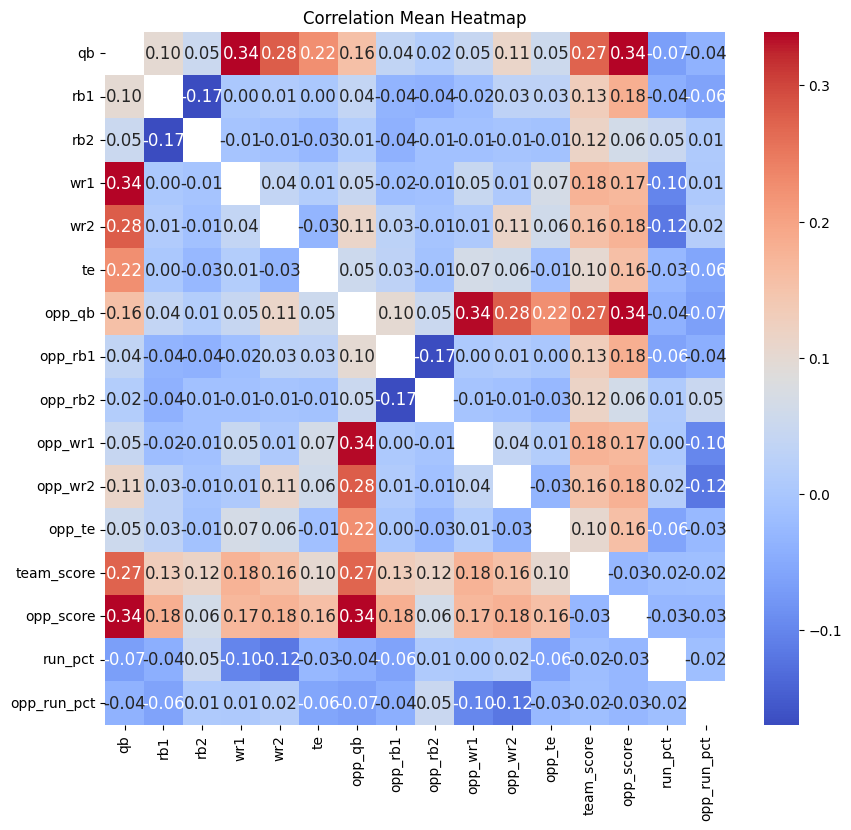

In [40]:
plt.figure(figsize = (10, 9))

mask = np.eye(corr_mean.shape[0], dtype=bool)

row_names = ['qb', 'rb1', 'rb2', 'wr1', 'wr2', 'te', 'opp_qb', 'opp_rb1', 'opp_rb2', 'opp_wr1', 'opp_wr2', 'opp_te', 'team_score', 'opp_score', 'run_pct', 'opp_run_pct']
col_names = row_names

sns.heatmap(corr_mean, annot = True, cmap = 'coolwarm', fmt='.2f', annot_kws={'size': 12}, mask = mask, xticklabels = col_names, yticklabels = row_names)
plt.title("Correlation Mean Heatmap")
plt.show()

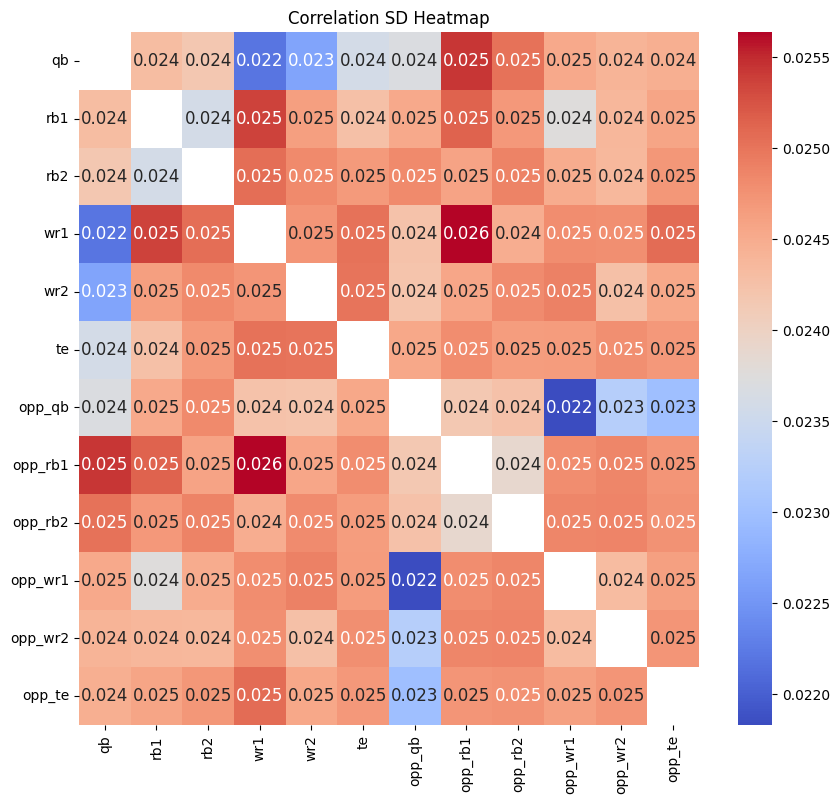

In [ ]:
plt.figure(figsize = (10, 9))

mask = np.eye(corr_sd.shape[0], dtype=bool)

row_names = ['qb', 'rb1', 'rb2', 'wr1', 'wr2', 'te', 'opp_qb', 'opp_rb1', 'opp_rb2', 'opp_wr1', 'opp_wr2', 'opp_te']
col_names = row_names

sns.heatmap(corr_sd, annot = True, cmap = 'coolwarm', fmt='.3f', annot_kws={'size': 12}, mask = mask, xticklabels = col_names, yticklabels = row_names)
plt.title("Correlation SD Heatmap")
plt.show()

In [39]:
data.to_csv('data.csv')
!cp data.csv "drive/My Drive/WSABI"
games.to_csv('games.csv')
!cp games.csv "drive/My Drive/WSABI"
plays.to_csv('plays.csv')
!cp plays.csv "drive/My Drive/WSABI"